In [1]:
import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

import matplotlib.pyplot as plt

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [2]:
model_paths = ["Save_File/All_building_seperate_05_31/5.ckpt"]

data_paths = ["Refined_Data/Seperated_Data/5.csv"]

start_point = -1000
duration = 168

# model_paths = ["Save_File/All_building_seperate_05_31/1/checkpoints/1.ckpt",
#                 "Save_File/All_building_seperate_05_31/2/checkpoints/2.ckpt",
#                 "Save_File/All_building_seperate_05_31/3/checkpoints/3.ckpt",
#                 "Save_File/All_building_seperate_05_31/4/checkpoints/4.ckpt",
#                 "Save_File/All_building_seperate_05_31/5/checkpoints/5.ckpt"]

# data_paths = ["Refined_Data/Seperated_Data/1.csv",
#                 "Refined_Data/Seperated_Data/2.csv",
#                 "Refined_Data/Seperated_Data/3.csv",
#                 "Refined_Data/Seperated_Data/4.csv",
#                 "Refined_Data/Seperated_Data/5.csv"]

input_length = 168
output_length = 6

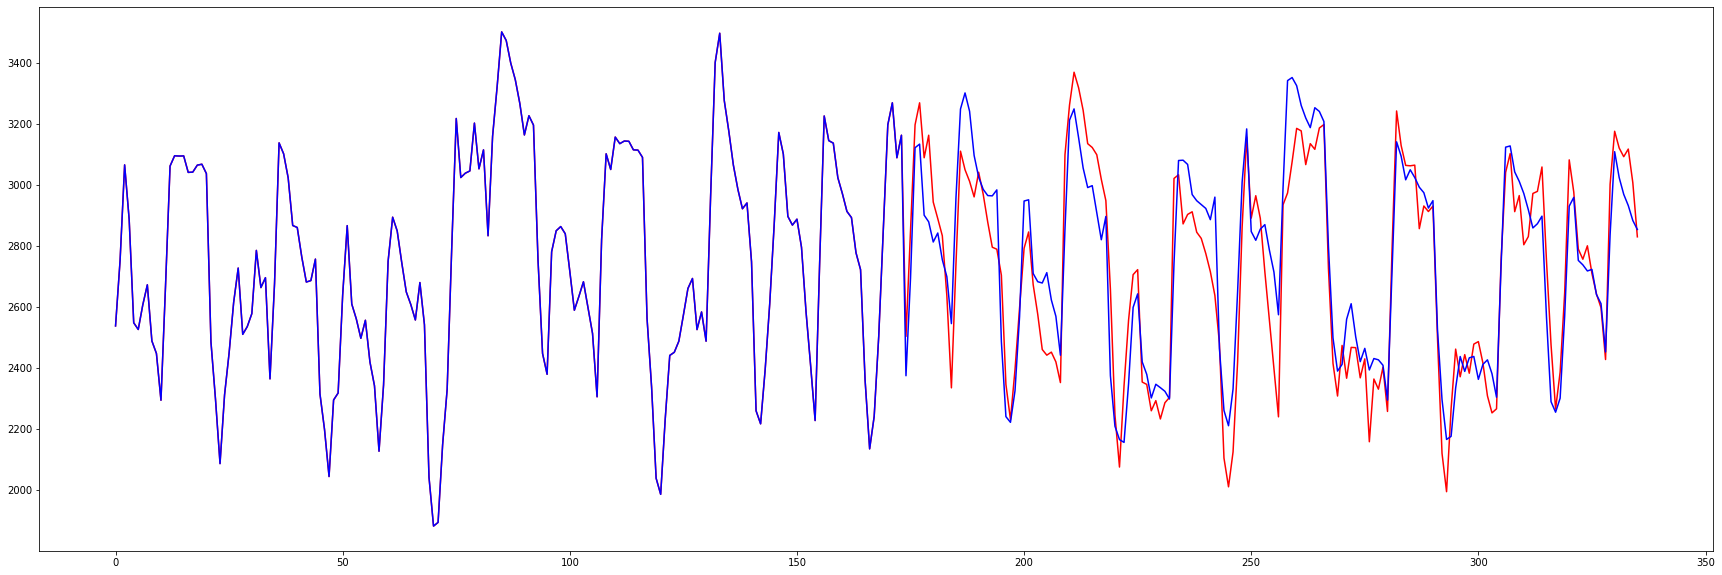

In [3]:
for i in range(len(model_paths)):
    now_dataframe = pd.read_csv(data_paths[i], index_col=0)[start_point:start_point+input_length+duration]
    now_dataframe['num'] = now_dataframe['num'].apply(str)
    now_dataframe['Week'] = now_dataframe['Week'].apply(str)
    now_dataframe['24Hour'] = now_dataframe['24Hour'].apply(str)
    
    now_best_tft = TemporalFusionTransformer.load_from_checkpoint(model_paths[i])

    original = now_dataframe.iloc[0:input_length+output_length]["kWH"].tolist()
    prediction = now_dataframe.iloc[0:input_length+output_length]["kWH"].tolist()

    total_cycle = (len(now_dataframe) - input_length - output_length) // output_length

    for k in range(total_cycle):
        now_start_point = k*output_length

        encoder_data = now_dataframe.iloc[now_start_point:now_start_point+input_length].copy()
        decoder_data = now_dataframe.iloc[now_start_point+input_length:now_start_point+input_length+output_length].copy()
        new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

        # get prediction, original data
        raw_predictions= now_best_tft.predict(new_prediction_data, mode="prediction").numpy().tolist()[0]
        originals = now_dataframe.iloc[now_start_point+input_length : now_start_point+input_length+output_length]["kWH"].tolist()

        prediction.extend(raw_predictions)
        original.extend(originals)

        # for next step, change dataframe's original value to predicted value
        for p in range(output_length):
            now_dataframe.iloc[now_start_point+input_length+p, now_dataframe.columns.get_loc("kWH")] = raw_predictions[p]

            
    plt.rcParams["figure.figsize"] = (30,10)
    fig = plt.figure()
    graph = fig.add_subplot(1, 1, 1)
    graph.plot(original, color='red')
    graph.plot(prediction, color='blue')
    plt.show()
    
    

    break
    

In [4]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

smape_loss = smape(np.array(prediction[168:]), np.array(original[168:]))
print(smape_loss)

4.0041422886674685
